**2**

In [48]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib as mlp
import matplotlib.pyplot as plt

import seaborn as sns       

from numpy                 import array
from sklearn               import metrics
from sklearn.preprocessing import StandardScaler  
from tensorflow.keras.models          import Sequential 
from tensorflow.keras.layers          import LSTM
from tensorflow.keras.layers import Dense, Dropout

**Type de données collectées :**

Données climatiques : le gaz est utilisé majorité en Europe pour la production d'électricité et de chaleur. Les variations de température ont donc un impact sur la demande de gaz naturel. Plus il fait froid, plus la demande en gaz naturel augmente, d'où l'importance de remplir au maximum les stockages de gaz naturel en été, lorsque les prix sur les marchés sont généralement moins élevés. 

Données de stockage : 

Lorsque les niveaux de stockage sont bas, cela crée une tension sur les marchés. Pour garantir la sécurité énergétique, les importations de gaz par pipeline ou LNG augmentent. 

Données d'approvisionnement en gaz :

J'ai pris en compte le gaz acheminé par pipeline et par LNG en Europe. Depuis la guerre en Ukraine, La Russie, principal fournisseur de gaz en Europe, a fermé petit à petit les chemins d'approvisionnement. La grande dépendance de certains états européens de l'est (notamment l'Allemagne) en gaz russe a créé une hausse des prix fulgurante en 2022. 

Données de marché :

Le STOXX 600 est un indice boursier composite pour l'Europe qui reflète le niveau d'activité des marchés financiers européens et illustre la corrélation entre le prix à terme du gaz naturel en tant que produit de base et le marché.

In [93]:
ttf= pd.read_csv(r'C:\Users\Nomade05\Other\Desktop\memoire_elie\TTF\TTF_price.csv')
stoxx = pd.read_csv(r'C:\Users\Nomade05\Other\Desktop\memoire_elie\STOXX600\stoxx_1.csv')
temperature = pd.read_csv(r'C:\Users\Nomade05\Other\Desktop\temp\temp.csv')
ng = pd.read_csv(r'C:\Users\Nomade05\Other\Desktop\memoire_elie\NG_volume\ngvolume.csv')
inventory = pd.read_csv(r'C:\Users\Nomade05\Other\Desktop\memoire_elie\Inventory\inventory.csv')



**TTF**

In [50]:
ttf

,Date,TTF open price
0,2018-01-31,17.880
1,2018-02-01,18.150
2,2018-02-02,18.160
3,2018-02-05,17.590
4,2018-02-06,17.880
...,...,...
1266,2023-02-06,58.110
1267,2023-02-07,57.400
1268,2023-02-08,53.685
1269,2023-02-09,52.735


**STOXX 600**

In [51]:
stoxx

,Date,stoxx600 close price,stoxx600 open price,stoxx600 high price,stoxx600 low price
0,2018-01-31,393.4,395.1,395.7,393.0
1,2018-02-01,391.2,395.4,396.9,390.9
2,2018-02-02,386.3,392.0,392.0,383.4
3,2018-02-05,380.2,382.1,383.8,368.4
4,2018-02-06,371.1,368.3,378.6,366.6
...,...,...,...,...,...
1277,2023-02-03,460.1,457.8,460.7,456.1
1278,2023-02-06,456.7,458.2,458.5,454.8
1279,2023-02-07,457.4,457.7,461.2,456.2
1280,2023-02-08,459.0,460.7,462.5,458.2


**Natural gas volume**

In [52]:
ng

,Date,Russia,Norway,Denmark,Netherland,Romania,Azerbaïdjan,Algeria,Libya,LNG,Total
0,2018-01-31,4.001608e+09,2.283298e+09,0,1.394093e+09,2.911414e+08,0,1343636635,134004193,6.499597e+08,1.009774e+10
1,2018-02-01,4.005695e+09,2.363729e+09,0,1.414978e+09,2.897282e+08,0,1359645226,137670746,5.449509e+08,1.011640e+10
2,2018-02-02,4.106424e+09,2.366310e+09,0,1.434468e+09,2.902427e+08,0,1353655349,137647764,4.496210e+08,1.013837e+10
3,2018-02-03,4.091317e+09,2.375302e+09,0,1.465383e+09,2.877026e+08,0,1323158120,126608602,3.156815e+08,9.985152e+09
4,2018-02-04,4.095216e+09,2.135495e+09,0,1.478725e+09,2.859898e+08,0,1327621055,134166998,3.704502e+08,9.827665e+09
...,...,...,...,...,...,...,...,...,...,...,...
1832,2023-02-06,7.473527e+08,2.282873e+09,236295036,4.259255e+08,2.504748e+08,365608831,971340731,76015735,1.117045e+09,6.472932e+09
1833,2023-02-07,7.721550e+08,2.722883e+09,240325299,4.294571e+08,2.506408e+08,360482573,969793122,75988143,1.306074e+09,7.127799e+09
1834,2023-02-08,7.977022e+08,2.680579e+09,224692776,4.248032e+08,2.518045e+08,360551667,957521683,76099505,1.320554e+09,7.094308e+09
1835,2023-02-09,7.894015e+08,2.762461e+09,256346408,4.386408e+08,2.512024e+08,349220527,969828518,108611150,1.333907e+09,7.259619e+09


**Temperatures**

In [53]:
temperature.rename(columns={'    DATE': 'Date'}, inplace=True)
temperature

,Date,uk,austria,croatia,cyprus,czech_republic,denmark,estonia,finland,france,...,luxembourg,netherlands,poland,portugal,romania,slovakia,slovenia,spain,sweden,AVG.(celsius)
0,2018-01-31,4.3,5.6,8.1,NaN,7.7,4.9,0.7,NaN,7.5,...,5.3,6.3,2.0,13.1,0.5,1.3,5.2,6.8,-5.5,4.405000
1,2018-02-01,3.6,3.8,11.2,NaN,5.7,3.2,1.9,NaN,5.2,...,1.0,4.9,3.2,11.8,1.6,4.0,9.4,4.9,-6.7,4.450000
2,2018-02-02,4.1,1.1,6.0,NaN,4.5,3.3,1.6,NaN,5.2,...,0.8,4.5,NaN,10.2,4.1,3.1,0.5,2.7,-14.4,2.921053
3,2018-02-03,2.4,NaN,4.5,NaN,3.5,NaN,0.6,NaN,4.9,...,0.8,3.2,NaN,10.6,7.5,1.8,0.3,4.2,-13.7,2.331250
4,2018-02-04,2.9,NaN,4.8,NaN,2.1,NaN,NaN,NaN,3.7,...,NaN,2.5,NaN,9.6,7.5,1.0,0.3,3.9,-18.5,1.900000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1832,2023-02-06,4.5,NaN,1.1,NaN,NaN,0.8,1.6,NaN,4.4,...,NaN,4.5,NaN,NaN,NaN,NaN,NaN,4.8,0.3,2.880000
1833,2023-02-07,1.6,NaN,1.6,NaN,NaN,0.1,1.1,NaN,2.3,...,0.6,1.6,NaN,NaN,NaN,NaN,NaN,3.4,0.5,1.909091
1834,2023-02-08,0.2,NaN,0.8,NaN,NaN,0.5,2.3,NaN,0.8,...,0.3,0.9,NaN,NaN,NaN,0.2,NaN,6.2,1.1,1.716667
1835,2023-02-09,3.4,NaN,2.5,NaN,NaN,2.1,2.1,0.7,4.6,...,NaN,4.4,NaN,NaN,NaN,NaN,NaN,6.3,1.3,3.127273


**Gas in storage**

In [54]:
inventory.rename(columns={'Gas Day Start': 'Date'}, inplace=True)
inventory

,Date,Gas in storage (TWh)
0,2018-01-31,541.5107
1,2018-02-01,535.3090
2,2018-02-02,528.7890
3,2018-02-03,523.0769
4,2018-02-04,516.8978
...,...,...
1832,2023-02-06,781.1436
1833,2023-02-07,773.8454
1834,2023-02-08,766.4737
1835,2023-02-09,758.8946


**4**

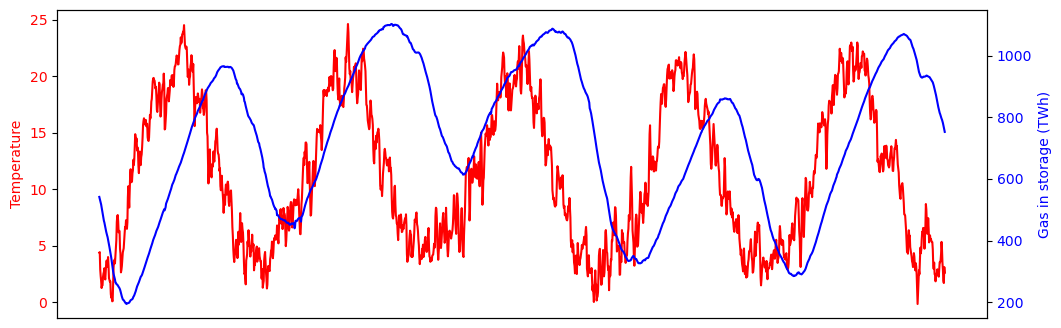

In [55]:
fig, ax1 = plt.subplots(figsize=(12,4))

ax1.plot(temperature['Date'], temperature['AVG.(celsius)'], 'r-', label='Temperature')
ax1.set_xlabel('Date')
ax1.set_ylabel('Temperature', color='r')
ax1.tick_params(axis='y', labelcolor='r')
 

ax1.set_xlabel('')
ax1.xaxis.set_ticks([])

# Créer un second axe Y
ax2 = ax1.twinx()
ax2.plot(inventory['Date'], inventory['Gas in storage (TWh)'], 'b-', label='Gas in storage (TWh)')
ax2.set_ylabel('Gas in storage (TWh)', color='b')
ax2.tick_params(axis='y', labelcolor='b')

In [56]:
stoxx = stoxx.replace([np.inf, -np.inf], np.nan).dropna()

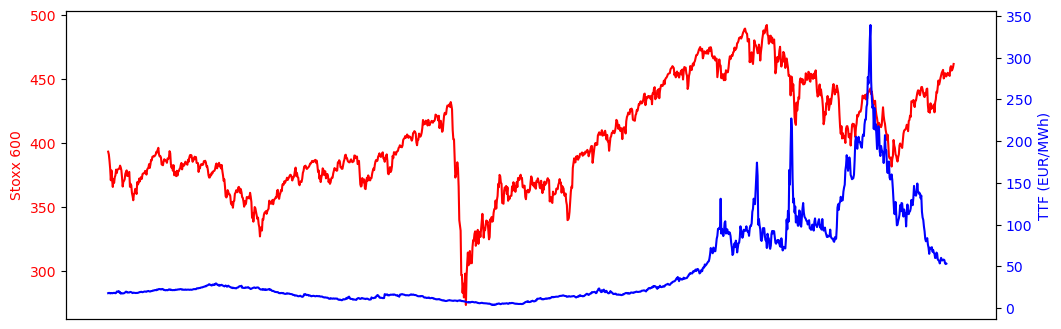

In [57]:
fig, ax1 = plt.subplots(figsize=(12,4))
ax1.plot(stoxx['stoxx600 close price'], 'r-', label='Stoxx 600')
ax1.set_ylabel('Stoxx 600', color='r')
ax1.tick_params(axis='y', labelcolor='r')

ax1.set_xlabel('')
ax1.xaxis.set_ticks([])

ax2 = ax1.twinx()
ax2.plot(ttf['TTF open price'], 'b-', label='TTF')
ax2.set_ylabel('TTF (EUR/MWh)', color='b')
ax2.tick_params(axis='y', labelcolor='b')

In [58]:
ng.tail(3)

,Date,Russia,Norway,Denmark,Netherland,Romania,Azerbaïdjan,Algeria,Libya,LNG,Total
1834,2023-02-08,797702196.0,2.680579e+09,224692776,424803175.4,2.518045e+08,360551667,957521683,76099505,1.320554e+09,7.094308e+09
1835,2023-02-09,789401461.0,2.762461e+09,256346408,438640823.7,2.512024e+08,349220527,969828518,108611150,1.333907e+09,7.259619e+09
1836,2023-02-10,792325800.0,2.491304e+09,247261236,434564742.5,2.509948e+08,349131215,968246178,97790614,1.273458e+09,6.905077e+09


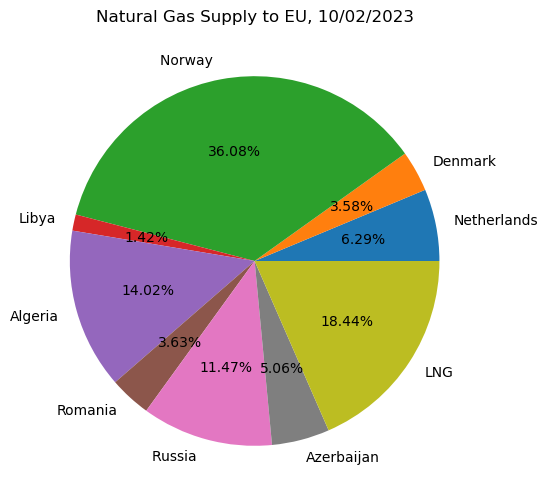

In [59]:
fig=plt.figure(figsize=(12,6))
df_ng = pd.DataFrame([
    ['Netherlands', 434564742.5], ['Denmark', 247261236],['Norway ', 2491303989],  ['Libya', 97790614], ['Algeria', 968246178], ['Romania', 250994763.9],
    ['Russia ', 792325800],  ['Azerbaijan', 349131215 ], ['LNG', 1273458096]],columns=['country', 'supply'])
plt.pie(df_ng['supply'], labels=df_ng['country'], autopct='%1.2f%%')
plt.title('Natural Gas Supply to EU, 10/02/2023')
plt.show()

**5**

In [60]:
df0 = pd.merge(ng, inventory,on="Date",how="outer")
df1 = pd.merge(df0, temperature,on='Date',how="outer")
df2 = pd.merge(df1, stoxx,on='Date',how="outer")
df = pd.merge(df2, ttf,on='Date',how="outer")

In [61]:
df.isnull().sum()

Date                       0
Russia                     0
Norway                     0
Denmark                    0
Netherland                 0
Romania                    0
Azerbaïdjan                0
Algeria                    0
Libya                      0
LNG                        0
Total                      0
Gas in storage (TWh)       0
uk                        41
austria                  154
croatia                    8
cyprus                  1837
czech_republic           104
denmark                   66
estonia                  208
finland                  917
france                    20
germany                  209
hungary                  131
ireland                    0
italy                     74
latvia                   482
luxembourg               105
netherlands               38
poland                   259
portugal                 829
romania                  147
slovakia                 227
slovenia                 152
spain                     12
sweden        

In [62]:
df = df.fillna(method='ffill')

In [63]:
df.columns
df = df.drop('cyprus',axis=1)

In [64]:
df.isnull().sum()

Date                     0
Russia                   0
Norway                   0
Denmark                  0
Netherland               0
Romania                  0
Azerbaïdjan              0
Algeria                  0
Libya                    0
LNG                      0
Total                    0
Gas in storage (TWh)     0
uk                       0
austria                  0
croatia                  0
czech_republic           0
denmark                  0
estonia                  0
finland                 65
france                   0
germany                  0
hungary                  0
ireland                  0
italy                    0
latvia                  40
luxembourg               0
netherlands              0
poland                   0
portugal                 0
romania                  0
slovakia                 0
slovenia                 0
spain                    0
sweden                   0
AVG.(celsius)            0
stoxx600 close price     0
stoxx600 open price      0
s

**6**

C:\Users\Nomade05\AppData\Local\Temp\ipykernel_25404\477614393.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr().round(2)


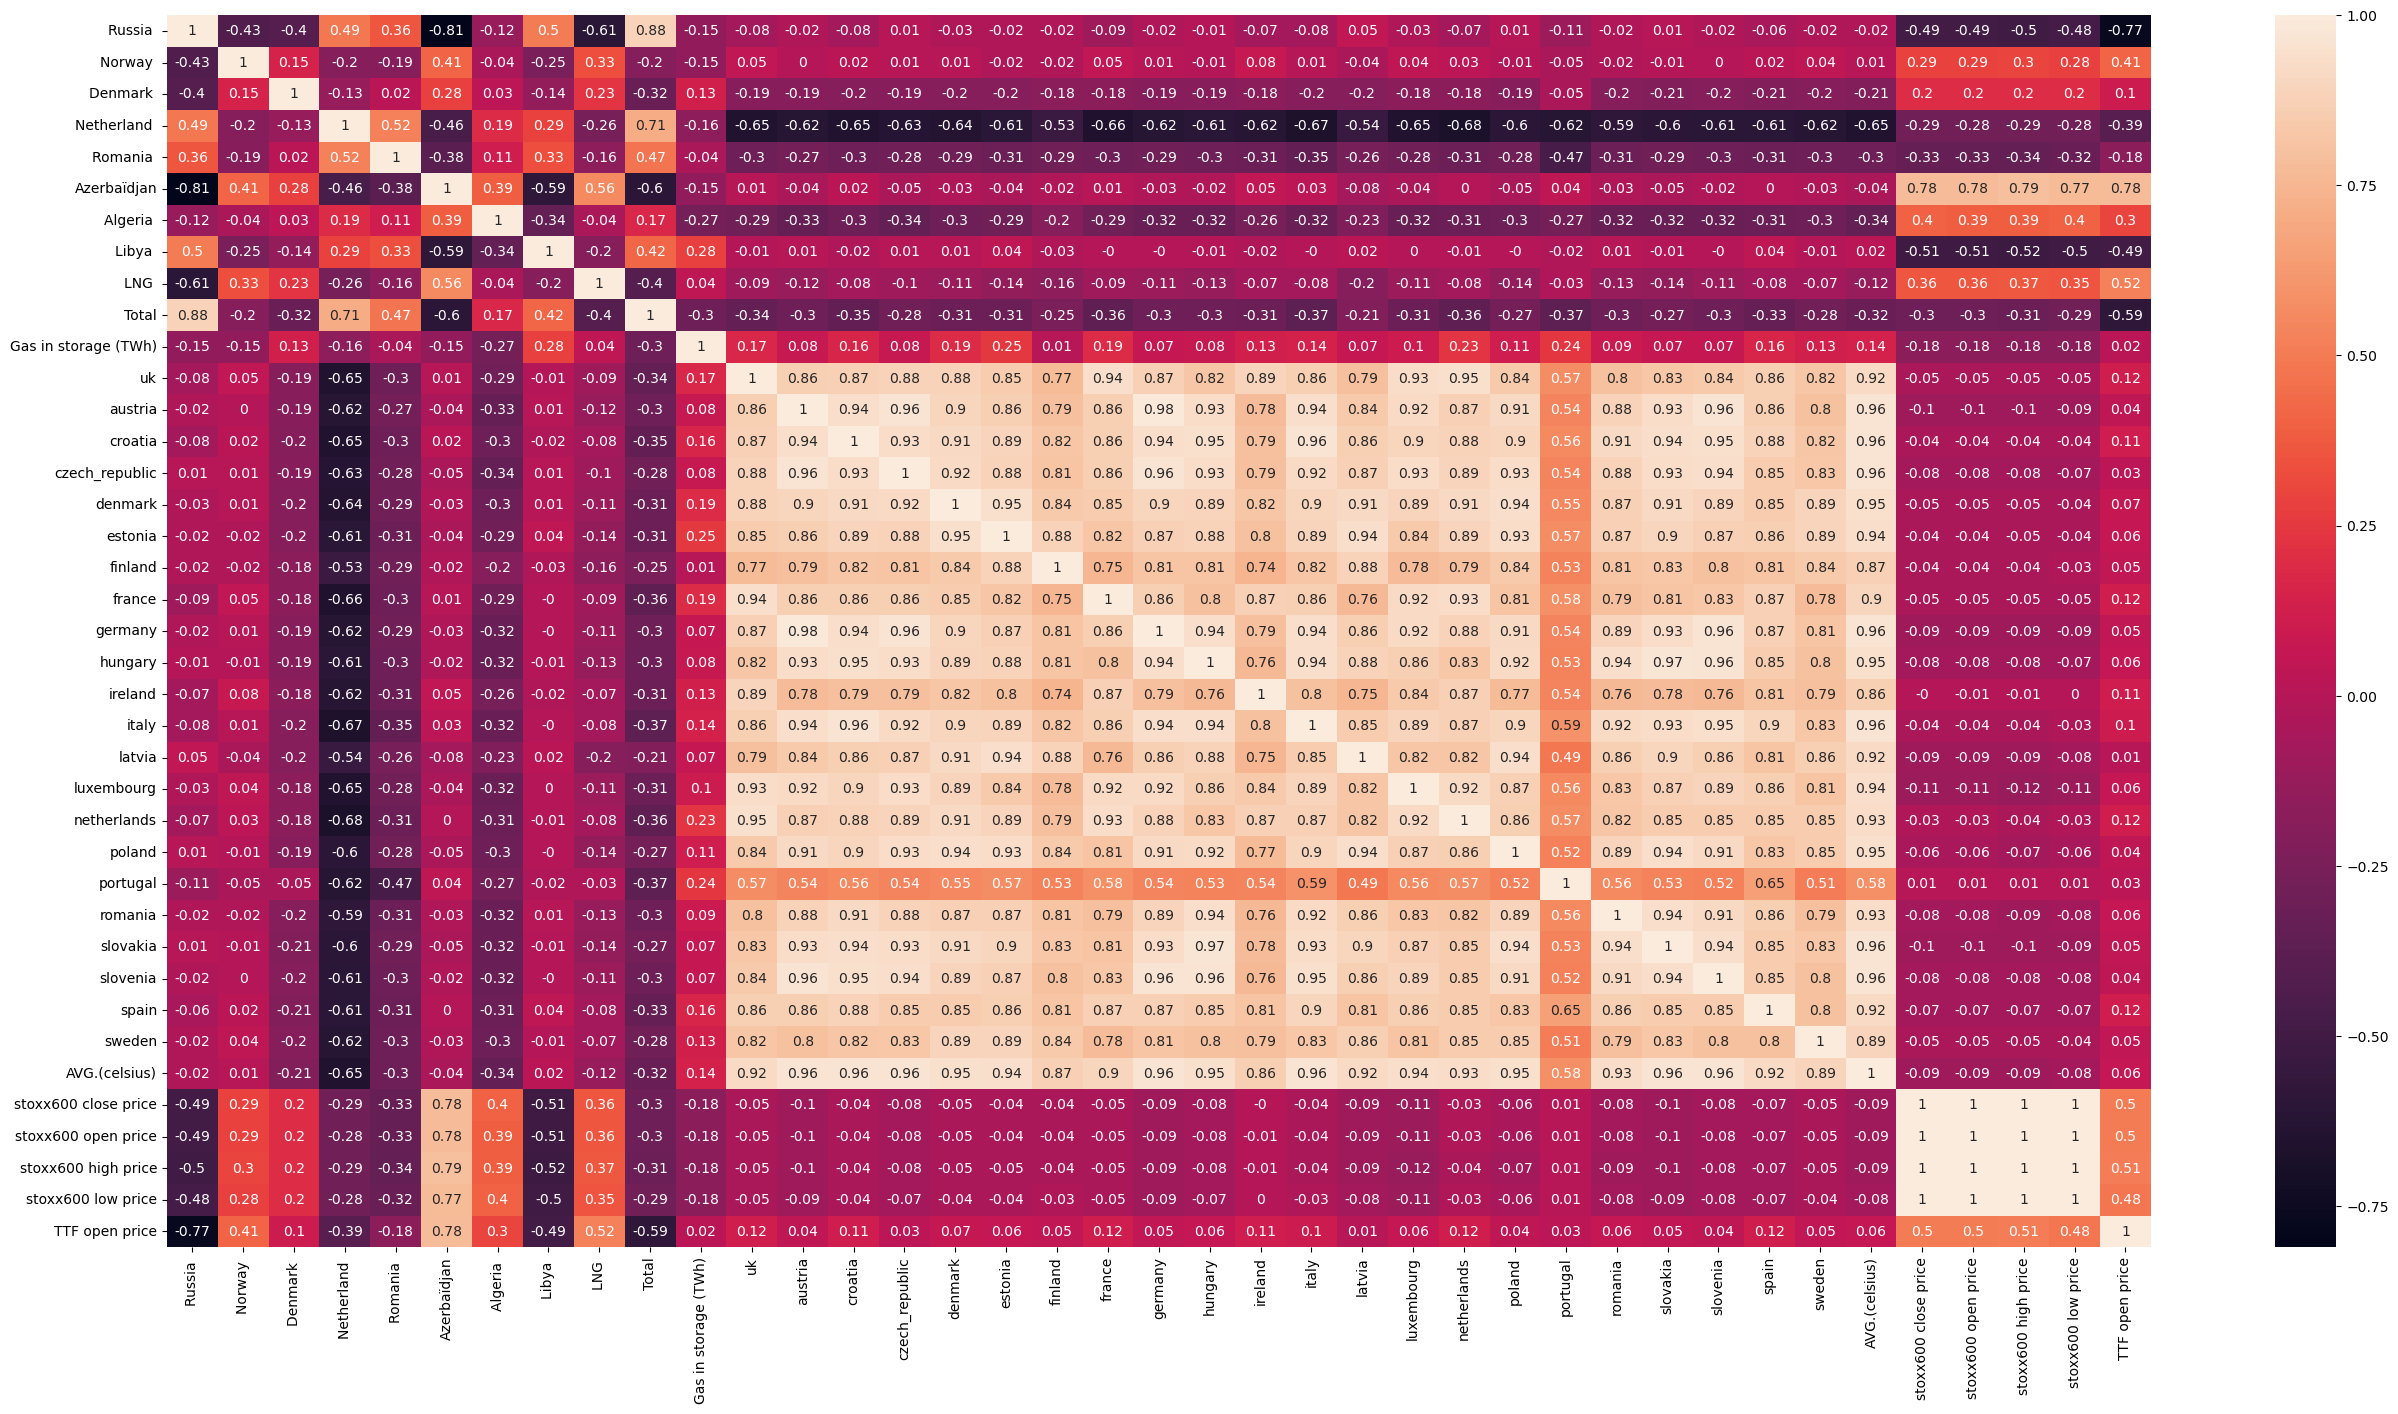

In [65]:
correlation_matrix = df.corr().round(2)
plt.figure(figsize=(32,16))
sns.heatmap(data=correlation_matrix, annot = True)
plt.show()

As you can see from the graph above :
- The correlation between TTF gas price and stoxx600 is 0.5. 
- The correlation with gas imports into Azerbaidjan is 0.78.  
- Positive correlation bewteen Norway and Azerbaidjan. 
- Negative correlation with Russia exports, lybian exports and European stocks

In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1837 entries, 0 to 1836
Data columns (total 40 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  1837 non-null   object 
 1   Russia                1837 non-null   float64
 2   Norway                1837 non-null   float64
 3   Denmark               1837 non-null   int64  
 4   Netherland            1837 non-null   float64
 5   Romania               1837 non-null   float64
 6   Azerbaïdjan           1837 non-null   int64  
 7   Algeria               1837 non-null   int64  
 8   Libya                 1837 non-null   int64  
 9   LNG                   1837 non-null   float64
 10  Total                 1837 non-null   float64
 11  Gas in storage (TWh)  1837 non-null   float64
 12  uk                    1837 non-null   float64
 13  austria               1837 non-null   float64
 14  croatia               1837 non-null   float64
 15  czech_republic       

In [67]:
time_df = pd.to_datetime(df['Date'])
time_df.head(4)

0   2018-01-31
1   2018-02-01
2   2018-02-02
3   2018-02-03
Name: Date, dtype: datetime64[ns]

In [68]:
df.columns

Index(['Date', 'Russia ', 'Norway ', 'Denmark ', 'Netherland ', 'Romania ',
       'Azerbaïdjan', 'Algeria ', 'Libya ', 'LNG ', 'Total',
       'Gas in storage (TWh)', 'uk', 'austria', 'croatia', 'czech_republic',
       'denmark', 'estonia', 'finland', 'france', 'germany', 'hungary',
       'ireland', 'italy', 'latvia', 'luxembourg', 'netherlands', 'poland',
       'portugal', 'romania', 'slovakia', 'slovenia', 'spain', 'sweden',
       'AVG.(celsius)', 'stoxx600 close price', 'stoxx600 open price',
       'stoxx600 high price', 'stoxx600 low price', 'TTF open price'],
      dtype='object')

**7**

In [69]:
df_input=df[[
       'Azerbaïdjan', 'Russia ', 'Norway ', 'Netherland ', 'Libya ', 'LNG ',
       'stoxx600 open price', 'stoxx600 high price', 'stoxx600 low price', 'TTF open price']]
df_input.head(4)

,Azerbaïdjan,Russia,Norway,Netherland,Libya,LNG,stoxx600 open price,stoxx600 high price,stoxx600 low price,TTF open price
0,0,4.001608e+09,2.283298e+09,1.394093e+09,134004193,649959682.0,395.1,395.7,393.0,17.88
1,0,4.005695e+09,2.363729e+09,1.414978e+09,137670746,544950864.0,395.4,396.9,390.9,18.15
2,0,4.106424e+09,2.366310e+09,1.434468e+09,137647764,449621035.0,392.0,392.0,383.4,18.16
3,0,4.091317e+09,2.375302e+09,1.465383e+09,126608602,315681547.0,392.0,392.0,383.4,18.16


Réseau LSTM (long short-term memory)

Un réseau LSTM est un réseau de neurones récurrent (RNN, Recurrent Neural Network) qui traite les données d’entrée en effectuant une boucle à chaque pas de temps tout en mettant à jour l’état du RNN. L’état du RNN contient des informations mémorisées sur tous les pas de temps précédents

In [70]:
ss = StandardScaler()
df_ss = ss.fit_transform(df_input)

In [71]:
Xtrain = []
Ytrain = []

future = 1   
past = 7 

In [72]:
for i in range(past, len(df_ss) - future +1):
    Xtrain.append(df_ss[i - past:i, 0:df_input.shape[1]])
    Ytrain.append(df_ss[i + future - 1:i + future, 9])

In [73]:
Xtrain = np.array(Xtrain)
Ytrain = np.array(Ytrain)

In [74]:
Xtrain.shape

(1830, 7, 10)

In [75]:
Ytrain.shape

(1830, 1)

In [76]:
model = Sequential()
model.add(LSTM(128, activation='relu', input_shape=(Xtrain.shape[1], Xtrain.shape[2]), return_sequences=False)) #True
#model.add(LSTM(64, activation='relu', return_sequences=False))
model.add(Dropout(0.15))
model.add(Dense(Ytrain.shape[1]))

In [77]:
model.compile(optimizer='adam', loss='mse')
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               71168     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 71297 (278.50 KB)
Trainable params: 71297 (278.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [78]:
history = model.fit(Xtrain, Ytrain, epochs=100, batch_size=128, validation_split=0.1, verbose=1)

Epoch 1/100

13/13 [==============================] - 2s 31ms/step - loss: 0.2851 - val_loss: 0.9143
Epoch 2/100
13/13 [==============================] - 0s 12ms/step - loss: 0.0977 - val_loss: 0.5917
Epoch 3/100
13/13 [==============================] - 0s 9ms/step - loss: 0.0538 - val_loss: 0.2385
Epoch 4/100
13/13 [==============================] - 0s 8ms/step - loss: 0.0345 - val_loss: 0.1981
Epoch 5/100
13/13 [==============================] - 0s 8ms/step - loss: 0.0291 - val_loss: 0.1543
Epoch 6/100
13/13 [==============================] - 0s 8ms/step - loss: 0.0260 - val_loss: 0.1436
Epoch 7/100
13/13 [==============================] - 0s 8ms/step - loss: 0.0243 - val_loss: 0.1354
Epoch 8/100
13/13 [==============================] - 0s 9ms/step - loss: 0.0236 - val_loss: 0.1469
Epoch 9/100
13/13 [==============================] - 0s 8ms/step - loss: 0.0229 - val_loss: 0.1380
Epoch 10/100
13/13 [==============================] - 0s 8ms/step - loss: 0.0182 - val_loss: 0.1217
Epoch 

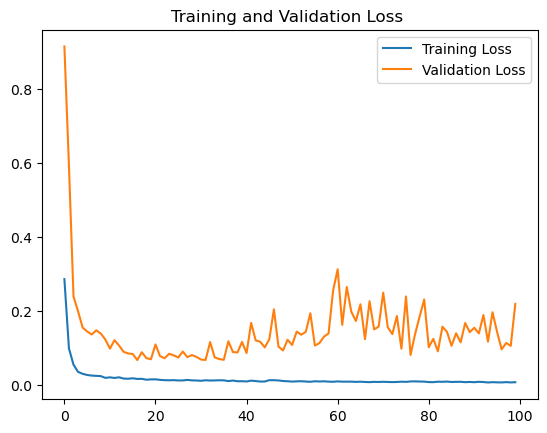

In [79]:
plt.plot(history.history['loss']    , label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss ')
plt.legend()

In [80]:
past_n = 1201
predict_days_n = 1200  #let us predict past 15 days

predict_dates = pd.date_range(list(time_df)[-past_n], periods= predict_days_n).tolist()
print(predict_dates)

[Timestamp('2019-10-29 00:00:00', freq='D'), Timestamp('2019-10-30 00:00:00', freq='D'), Timestamp('2019-10-31 00:00:00', freq='D'), Timestamp('2019-11-01 00:00:00', freq='D'), Timestamp('2019-11-02 00:00:00', freq='D'), Timestamp('2019-11-03 00:00:00', freq='D'), Timestamp('2019-11-04 00:00:00', freq='D'), Timestamp('2019-11-05 00:00:00', freq='D'), Timestamp('2019-11-06 00:00:00', freq='D'), Timestamp('2019-11-07 00:00:00', freq='D'), Timestamp('2019-11-08 00:00:00', freq='D'), Timestamp('2019-11-09 00:00:00', freq='D'), Timestamp('2019-11-10 00:00:00', freq='D'), Timestamp('2019-11-11 00:00:00', freq='D'), Timestamp('2019-11-12 00:00:00', freq='D'), Timestamp('2019-11-13 00:00:00', freq='D'), Timestamp('2019-11-14 00:00:00', freq='D'), Timestamp('2019-11-15 00:00:00', freq='D'), Timestamp('2019-11-16 00:00:00', freq='D'), Timestamp('2019-11-17 00:00:00', freq='D'), Timestamp('2019-11-18 00:00:00', freq='D'), Timestamp('2019-11-19 00:00:00', freq='D'), Timestamp('2019-11-20 00:00:00'

In [81]:
prediction = model.predict(Xtrain[-predict_days_n:]) 

38/38 [==============================] - 0s 2ms/step


In [82]:
prediction_copies = np.repeat(prediction, df_input.shape[1], axis=-1)
Y_prediction_future = ss.inverse_transform(prediction_copies)[:,9]

In [83]:
forecast_dates = []
for time_i in predict_dates:
    forecast_dates.append(time_i.date())
    
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'TTF open Price':Y_prediction_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])

In [84]:
df_forecast.columns

Index(['Date', 'TTF open Price'], dtype='object')

In [85]:
print(df_forecast.columns)

Index(['Date', 'TTF open Price'], dtype='object')


In [86]:
df_forecast.columns = df_forecast.columns.str.strip()

In [87]:
df.columns

Index(['Date', 'Russia ', 'Norway ', 'Denmark ', 'Netherland ', 'Romania ',
       'Azerbaïdjan', 'Algeria ', 'Libya ', 'LNG ', 'Total',
       'Gas in storage (TWh)', 'uk', 'austria', 'croatia', 'czech_republic',
       'denmark', 'estonia', 'finland', 'france', 'germany', 'hungary',
       'ireland', 'italy', 'latvia', 'luxembourg', 'netherlands', 'poland',
       'portugal', 'romania', 'slovakia', 'slovenia', 'spain', 'sweden',
       'AVG.(celsius)', 'stoxx600 close price', 'stoxx600 open price',
       'stoxx600 high price', 'stoxx600 low price', 'TTF open price'],
      dtype='object')

In [88]:
df_forecast.columns

Index(['Date', 'TTF open Price'], dtype='object')

<Axes: xlabel='Date', ylabel='TTF open price'>

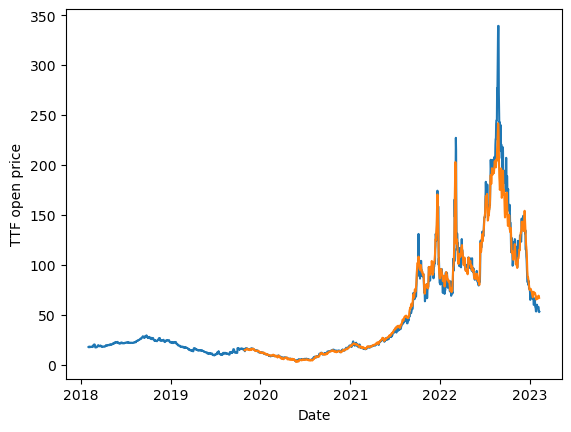

In [89]:
original = df[['Date']]
original = original.loc[original['Date'] >= '2018-01-31'].copy()
original['Date']=pd.to_datetime(original['Date'])
sns.lineplot(x=original['Date'], y=df[ 'TTF open price'])
sns.lineplot(x=df_forecast['Date'], y=df_forecast[ 'TTF open Price'])